<a href="https://colab.research.google.com/github/nataliasus121-source/Python_Project/blob/main/Exploratory_data_analysis_for_online_store_Portfolio_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1️⃣ **Project overview & Business Objective**

The **goal of this project** is to calculate statistical significance of A/B tests
for key funnel metrics using Python instead of online calculators.

The **Business Objective** is to understand whether the implemented changes (test group **B**) **improve key conversion metrics** compared to the control scenario (group **A**).



###**Metrics analyzed:**
| Metric                      | Description                                               |
| --------------------------- | --------------------------------------------------------- |
| **add_payment_info / session**  | Number of users who added payment information per session |
| **add_shipping_info / session** | Number of users who added shipping details per session    |
| **begin_checkout / session**    | Number of users who started checkout per session          |
| **new_accounts / session**      | Number of newly created accounts per session              |



In [ ]:
!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
from scipy.stats import norm

In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project="data-analytics-mate")

## **2️⃣ Data Collection and Preparation**

* Data is collected from BigQuery: **sessions, events, orders, accounts** as well as **A/B tests and experiment groups**.
* Important: the dataset includes **date, country, device, channel, and continent**, which allows further segmentation.
* The SQL query outputs a **unified table of events and sessions**, where each row represents a specific metric for a given segment.

### Business Meaning:

* We obtain **clean, structured metrics** required for conversion analysis.
* All events and sessions are consolidated into a **single DataFrame**, enabling consistent conversion and statistical significance calculations.

In [ ]:
query = """
with session_info as  (


  SELECT
      s.date,
      s.ga_session_id,
      sp.country,
      sp.device,
      sp.continent,
      sp.channel,
      ab.test,
      ab.test_group
  from `DA.ab_test` ab
  join `DA.session` s
  on ab.ga_session_id = s.ga_session_id
  join `DA.session_params` sp
  on ab.ga_session_id = sp.ga_session_id


),


sessions_with_orders as (
select
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group,
      count(distinct o.ga_session_id) as sessions_with_orders


from `DA.order` o
join session_info
on o.ga_session_id = session_info.ga_session_id
group by
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group
),


events as (
SELECT
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group,
      sp.event_name,
      count(sp.ga_session_id) as event_cnt
from `DA.event_params` sp
join session_info
on sp.ga_session_id = session_info.ga_session_id
group by
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group,
      sp.event_name
),


session as (
select
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group,
      count(distinct session_info.ga_session_id) as session_cnt
FROM session_info
group by
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group


),
account as (
select
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group,
      count (distinct acs.ga_session_id) as new_account_cnt
from `DA.account_session` acs
join session_info
 on acs.ga_session_id = session_info.ga_session_id
group by
      session_info.date,
      session_info.country,
      session_info.device,
      session_info.continent,
      session_info.channel,
      session_info.test,
      session_info.test_group
)




SELECT
      sessions_with_orders.date,
      sessions_with_orders.country,
      sessions_with_orders.device,
      sessions_with_orders.continent,
      sessions_with_orders.channel,
      sessions_with_orders.test,
      sessions_with_orders.test_group,
      'sessions with orders' as event_name,
      sessions_with_orders.sessions_with_orders as value


FROM
sessions_with_orders
 union all


SELECT
      events.date,
      events.country,
      events.device,
      events.continent,
      events.channel,
      events.test,
      events.test_group,
      event_name,
      events.event_cnt as value
FROM events
union all


SELECT
      session.date,
      session.country,
      session.device,
      session.continent,
      session.channel,
      session.test,
      session.test_group,
      'session' as event_name,
      session.session_cnt as value
FROM session
union all


SELECT
      account.date,
      account.country,
      account.device,
      account.continent,
      account.channel,
      account.test,
      account.test_group,
      'new account' as event_name,
      account.new_account_cnt as value
FROM account


"""


In [ ]:
query_test = client.query(query)  # Performing SQL-request
results = query_test.result()  # waiting for results
df = results.to_dataframe()
df.head()

,date,country,device,continent,channel,test,test_group,event_name,value
0,2020-11-01,Slovakia,mobile,Europe,Paid Search,2,2,new account,1
1,2020-11-04,Bolivia,desktop,Americas,Direct,2,1,new account,1
2,2020-11-05,Lebanon,mobile,Asia,Direct,2,2,new account,1
3,2020-11-06,Oman,desktop,Asia,Paid Search,2,2,new account,1
4,2020-11-06,Dominican Republic,desktop,Americas,Paid Search,2,1,new account,1


## 3️⃣**Metric definition logic**

Each metric is calculated as a conversion rate:

####**conversion rate = numerator / denominator**

Where:
- **numerator** — number of sessions where the specific event happened
- **denominator** — total number of sessions

The denominator is always "**session**", which allows all metrics to be comparable
and suitable for proportion-based statistical testing.


### **Business Meaning**:

* This standardization allows us to **compare experiment groups based on conversion efficiency**, rather than absolute event counts.



In [ ]:
# Definition of metrics and denominator
denominator = "session"


METRICS = {
    "add_payment_info": "add_payment_info",
    "add_shipping_info": "add_shipping_info",
    "begin_checkout": "begin_checkout",
    "new_accounts": "new account",
}



## **4️⃣ Statistical Function: proportion_z_test**

```python
def proportion_z_test(n_ev, d_ev, n_co, d_co):
    ...
```

* We calculate a **Z-test for the difference in conversion rates between control and test groups**.
* Input parameters:

  * `n_ev`, `d_ev` → control group (expected, group A)
  * `n_co`, `d_co` → test group (current, group B)
* Z-test formula:

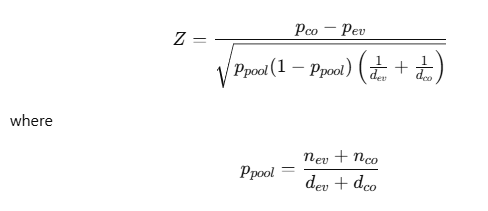


* The function returns:

  * **p_ev**, **p_co** — conversion rates for control and test groups
  * **uplift_%** — percentage change between groups
  * **z** — Z-statistic
  * **p_value** — probability that the observed difference is due to random variation

### **Business Meaning**:

* We do not only observe conversion differences, but also verify **whether those differences are statistically significant**, i.e. caused by the experiment rather than noise.




## **Statistical significance logic**

* **Null Hypothesis** ($H_0$): Conversion rates in the control (A) and test (B) groups are identical; any observed difference is due to random chance.

* **Z-Test**: A two-proportion z-test was used to compare conversion rates. This formula calculates how many standard deviations the test (B) group's result differs from the control group (A).

* **Significance Level** ($\alpha$): A standard threshold of 0.05 was chosen, corresponding to a 95% confidence level.

* **Significance Logic** (The Significant column):
  - If $P\text{-value} < 0.05$: The result is marked as **True** (statistically significant, unlikely to be a result of random chance).

  - Otherwise: The result is marked as **False **(not statistically significant).

A result is considered statistically significant if:
**p-value < 0.05**

This logic is applied:
- for total results per test
- for additional breakdowns (country, device, channel, continent)

All calculations are performed dynamically using loops,
so the solution can scale to any number of metrics or dimensions.


In [ ]:
#Z-test statistical significance function for proportions
def proportion_z_test(n_ev, d_ev, n_co, d_co):
    # n_ev, d_ev → контроль (expected)
    # n_co, d_co → тест (current)

    # Перевірка нульових знаменників
    if d_ev == 0 or d_co == 0:
        return None

    p_ev = n_ev / d_ev
    p_co = n_co / d_co

    # pooled proportion
    total_d = d_ev + d_co
    total_n = n_ev + n_co
    p_pool = total_n / total_d

    # Уникнення sqrt(0) або sqrt(negative)
    if p_pool <= 0 or p_pool >= 1:
        return None

    se = np.sqrt(p_pool * (1 - p_pool) * (1/d_ev + 1/d_co))
    if se == 0:
        return None

    z = (p_co - p_ev) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))
    uplift = (p_co - p_ev) / p_ev * 100 if p_ev > 0 else None

    return {
        "p_ev": p_ev,
        "p_co": p_co,
        "uplift_%": uplift,
        "z": z,
        "p_value": p_value
    }




## **5️⃣ Total Test-Level Calculation**

```python
for test_id in df['test'].unique():
    ...
```

* We aggregate **all sessions across all users** and calculate:

  * event counts (numerators) for control and test groups
  * session counts (denominators)
  * conversion rates
  * uplift, Z-statistic, p-value, and significance flag

### **Business Meaning**:

* This produces the **overall experiment result**, answering whether the change has a global impact on users.



In [ ]:
#Calculation of “total for the test”
results = []

for test_id in df['test'].unique():
    df_test = df[df['test'] == test_id]
    df_A = df_test[df_test['test_group'] == 1]  # контроль
    df_B = df_test[df_test['test_group'] == 2]  # тест

    for metric_name, event_name in METRICS.items():
        numerator_ev = df_A[df_A['event_name'] == event_name]['value'].sum()
        denominator_ev = df_A[df_A['event_name'] == denominator]['value'].sum()
        conv_ev = numerator_ev / denominator_ev if denominator_ev > 0 else np.nan

        numerator_co = df_B[df_B['event_name'] == event_name]['value'].sum()
        denominator_co = df_B[df_B['event_name'] == denominator]['value'].sum()
        conv_co = numerator_co / denominator_co if denominator_co > 0 else np.nan

        stat = proportion_z_test(numerator_ev, denominator_ev, numerator_co, denominator_co)
        z_stat = stat['z'] if stat else np.nan
        p_value = stat['p_value'] if stat else np.nan
        metric_change = stat['uplift_%'] if stat else np.nan
        significant = p_value < 0.05 if p_value is not None else False

        results.append({
            "test_number": test_id,
            "metric": metric_name,
            "numerator_ev": numerator_ev,
            "denominator_ev": denominator_ev,
            "conversion_ra_ev": conv_ev,
            "numerator_co": numerator_co,
            "denominator_co": denominator_co,
            "conversion_ra_co": conv_co,
            "metric_change_%": metric_change,
            "z_stat": z_stat,
            "p_value": p_value,
            "significant": significant,
            "dimension": "total",
            "dimension_value": "total"
        })
results_df = pd.DataFrame(results)
results_df



,test_number,metric,numerator_ev,denominator_ev,conversion_ra_ev,numerator_co,denominator_co,conversion_ra_co,metric_change_%,z_stat,p_value,significant,dimension,dimension_value
0,2,add_payment_info,2344,50637,0.046290,2409,50244,0.047946,3.576911,1.240994,0.214608,False,total,total
1,2,add_shipping_info,3480,50637,0.068724,3510,50244,0.069859,1.650995,0.709557,0.477979,False,total,total
2,2,begin_checkout,4262,50637,0.084168,4313,50244,0.085841,1.988164,0.952898,0.340642,False,total,total
3,2,new_accounts,4165,50637,0.082252,4184,50244,0.083274,1.241934,0.588793,0.556000,False,total,total
4,1,add_payment_info,1988,45362,0.043825,2229,45193,0.049322,12.542021,3.924884,0.000087,True,total,total
5,1,add_shipping_info,3034,45362,0.066884,3221,45193,0.071272,6.560481,2.603571,0.009226,True,total,total
6,1,begin_checkout,3784,45362,0.083418,4021,45193,0.088974,6.660587,2.978783,0.002894,True,total,total
7,1,new_accounts,3823,45362,0.084278,3681,45193,0.081451,-3.354299,-1.542883,0.122859,False,total,total
8,4,add_payment_info,3731,105079,0.035507,3601,105141,0.034249,-3.541234,-1.571106,0.116158,False,total,total
9,4,add_shipping_info,5128,105079,0.048801,4956,105141,0.047137,-3.411125,-1.785795,0.074132,False,total,total


## **6️⃣ Segment-Level Calculations (Dimensions)**

```python
DIMENSIONS = ["country", "device", "continent", "channel"]
for dim in DIMENSIONS:
    ...
```

* For each segmentation dimension:

  * Numerators and denominators are calculated separately
  * Conversion rates, uplift, Z-statistic, and p-value are computed
  * Statistical significance is flagged (`significant`)

### **Business Meaning**:

* This allows identification of **segments where the change performs better or worse**.
* For example, the effect may be significant on desktop but not on mobile.
* This insight is critical for **product decisions, marketing optimization, and targeting strategies**.



In [ ]:
#Sections (countries, devices, etc.)


DIMENSIONS = ["country", "device", "continent", "channel"]

for dim in DIMENSIONS:
    for value in df[dim].dropna().unique():
        df_dim = df[df[dim] == value]

        for test_id in df_dim['test'].unique():
            df_test = df_dim[df_dim['test'] == test_id]
            if df_test['test_group'].nunique() < 2:
                continue

            df_A = df_test[df_test['test_group'] == 1]  # контроль
            df_B = df_test[df_test['test_group'] == 2]  # тест

            for metric_name, event_name in METRICS.items():
                n_ev = df_A[df_A['event_name'] == event_name]['value'].sum()
                d_ev = df_A[df_A['event_name'] == denominator]['value'].sum()
                conv_ev = n_ev / d_ev if d_ev > 0 else np.nan

                n_co = df_B[df_B['event_name'] == event_name]['value'].sum()
                d_co = df_B[df_B['event_name'] == denominator]['value'].sum()
                conv_co = n_co / d_co if d_co > 0 else np.nan

                stat = proportion_z_test(n_ev, d_ev, n_co, d_co)
                z_stat = stat['z'] if stat else np.nan
                p_value = stat['p_value'] if stat else np.nan
                metric_change = stat['uplift_%'] if stat else np.nan
                significant = p_value < 0.05 if p_value is not None else False

                results.append({
                    "test_number": test_id,
                    "metric": metric_name,
                    "numerator_ev": n_ev,
                    "denominator_ev": d_ev,
                    "conversion_ra_ev": conv_ev,
                    "numerator_co": n_co,
                    "denominator_co": d_co,
                    "conversion_ra_co": conv_co,
                    "metric_change_%": metric_change,
                    "z_stat": z_stat,
                    "p_value": p_value,
                    "significant": significant,
                    "dimension": dim,
                    "dimension_value": value
                })


# ==========================
#Final DataFrame
# ==========================
results_df = pd.DataFrame(results)
results_df.head(20)

,test_number,metric,numerator_ev,denominator_ev,conversion_ra_ev,numerator_co,denominator_co,conversion_ra_co,metric_change_%,z_stat,p_value,significant,dimension,dimension_value
0,2,add_payment_info,2344,50637,0.046290,2409,50244,0.047946,3.576911,1.240994,0.214608,False,total,total
1,2,add_shipping_info,3480,50637,0.068724,3510,50244,0.069859,1.650995,0.709557,0.477979,False,total,total
2,2,begin_checkout,4262,50637,0.084168,4313,50244,0.085841,1.988164,0.952898,0.340642,False,total,total
3,2,new_accounts,4165,50637,0.082252,4184,50244,0.083274,1.241934,0.588793,0.556000,False,total,total
4,1,add_payment_info,1988,45362,0.043825,2229,45193,0.049322,12.542021,3.924884,0.000087,True,total,total
5,1,add_shipping_info,3034,45362,0.066884,3221,45193,0.071272,6.560481,2.603571,0.009226,True,total,total
6,1,begin_checkout,3784,45362,0.083418,4021,45193,0.088974,6.660587,2.978783,0.002894,True,total,total
7,1,new_accounts,3823,45362,0.084278,3681,45193,0.081451,-3.354299,-1.542883,0.122859,False,total,total
8,4,add_payment_info,3731,105079,0.035507,3601,105141,0.034249,-3.541234,-1.571106,0.116158,False,total,total
9,4,add_shipping_info,5128,105079,0.048801,4956,105141,0.047137,-3.411125,-1.785795,0.074132,False,total,total


## **7️⃣ Final DataFrame Structure**

Columns:

| Column           | Description                                   |
| ---------------- | --------------------------------------------- |
| test_number      | Experiment identifier                         |
| metric           | Metric name                                   |
| numerator_ev     | Control group event count                     |
| denominator_ev   | Control group session count                   |
| conversion_ra_ev | Control group conversion rate                 |
| numerator_co     | Test group event count                        |
| denominator_co   | Test group session count                      |
| conversion_ra_co | Test group conversion rate                    |
| metric_change_%  | Percentage uplift                             |
| z_stat           | Z-statistic                                   |
| p_value          | P-value                                       |
| significant      | Statistical significance flag                 |
| dimension        | Segmentation dimension (e.g. device, country) |
| dimension_value  | Dimension value (e.g. desktop, UA)            |

### **Business Meaning**:

* **Total rows (dimension = total)** → overall experiment results
* **Dimension rows** → segment-level analysis
* This provides a **complete picture** of where changes are effective and where they are not.

---

## **8️⃣ Why This Order of Calculations**

1. **Total experiment results first** — to understand the overall impact.
2. **Segment-level analysis next** — to detect heterogeneous effects across user groups.
3. Loops over metrics and dimensions ensure the solution is **scalable to any number of metrics and segments**.
4. The reusable `proportion_z_test` function guarantees **consistent statistical logic** for both total and segmented calculations.

---

## **9️⃣ How the Business Uses These Results**

* **metric_change_%** → magnitude of conversion change
* **p_value** → likelihood that the change is real
* **significant** → decision signal for rollout
* **dimension / dimension_value** → guidance for optimization, targeting, or follow-up experiments



## **Conclusions**

- The statistical significance was calculated for four funnel metrics using a
  proportion Z-test.
- Some tests show statistically significant changes (p-value < 0.05),
  while others do not.
- This confirms that observed metric changes should not be interpreted
  as meaningful unless statistical significance is achieved.
- The implemented approach allows scaling the analysis to additional metrics
  and dimensions without changes to the core logic.


In [ ]:
# Saving
results_df.to_excel("ab_test_results.xlsx", index=False)

from google.colab import files
files.download("ab_test_results.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###[ **File exce**l](https://docs.google.com/spreadsheets/d/19RVpOy3DeleAEH4L-0DVow7Xx5TnR80Z/edit?usp=sharing&ouid=111842347865975349280&rtpof=true&sd=true)

In [ ]:
results_df.to_csv("ab_test_results.csv", index=False)
from google.colab import files
files.download("ab_test_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **[File csv](https://drive.google.com/file/d/1dvBsvxt6zkhTb_me-jTMm9KrWe4KHzmr/view?usp=sharing)**

###[**Dashboards**](https://public.tableau.com/shared/9DTBBW5X4?:display_count=n&:origin=viz_share_link)